In [324]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
np.random.seed(23)

In [325]:
data = load_iris()
X, Y = data.data, data.target
X = X.reshape(X.shape[1], X.shape[0])
Y = Y.reshape(1, -1)
print(X.shape)
print(Y.shape)

(4, 150)
(1, 150)


In [326]:
X = (X - np.mean(X, axis=1, keepdims=True)) / np.std(X, axis=1, keepdims=True)

In [327]:
layer_dims = [4, 3, 2, 1]

In [328]:
def initialize_parameters_deep(layer_dims):
    parameters = {}
    L = len(layer_dims)
    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l - 1]) * 0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))

    return parameters 

In [329]:
parameters = initialize_parameters_deep(layer_dims)
for item in parameters.items():
    print(f'{item[0]} -- {item[1].shape}')

W1 -- (3, 4)
b1 -- (3, 1)
W2 -- (2, 3)
b2 -- (2, 1)
W3 -- (1, 2)
b3 -- (1, 1)


In [330]:
def linear_forward(A_prev, W, b):

    Z = np.dot(W, A_prev) + b

    cache = (A_prev, W, b)

    return Z, cache

In [331]:
Z, cache = linear_forward(X, parameters['W1'], parameters['b1'])
print(Z.shape)
print(cache)

(3, 150)
(array([[ 1.35197580e+00,  4.94032404e-01, -6.32018300e-01,
        -1.27547585e+00,  1.24473287e+00,  2.25925094e-01,
        -6.32018300e-01, -1.27547585e+00,  1.13748995e+00,
         3.33168018e-01, -6.85639763e-01, -1.27547585e+00,
         1.08386849e+00,  2.79546556e-01, -5.78396838e-01,
        -1.27547585e+00,  1.29835434e+00,  5.47653867e-01,
        -6.32018300e-01, -1.27547585e+00,  1.51284019e+00,
         7.08518253e-01, -4.71153914e-01, -1.16823292e+00,
         1.08386849e+00,  4.40410942e-01, -6.32018300e-01,
        -1.22185438e+00,  1.29835434e+00,  4.40410942e-01,
        -5.78396838e-01, -1.27547585e+00,  9.76625564e-01,
         1.72303632e-01, -6.32018300e-01, -1.27547585e+00,
         1.24473287e+00,  2.79546556e-01, -5.78396838e-01,
        -1.32909731e+00,  1.51284019e+00,  6.01275329e-01,
        -5.78396838e-01, -1.27547585e+00,  1.19111141e+00,
         4.40410942e-01, -5.24775376e-01, -1.27547585e+00,
         1.19111141e+00,  2.25925094e-01, -6.3

In [332]:
def sigmoid(Z):
    A = 1 / (1 + np.exp(Z))

    return A, Z

In [333]:
def tanh(Z):
    A = np.tanh(Z)

    return A, Z

In [334]:
def linear_activation_forward(A_prev, W, b, activation):

    if activation == 'sigmoid':
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)

    elif activation == 'tanh':
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = tanh(Z)

    cache = (linear_cache, activation_cache)

    return A, cache 

In [335]:
A, cache = linear_activation_forward(X, parameters['W1'], parameters['b1'], 'tanh')
print(A.shape)

(3, 150)


In [336]:
def L_model_forward(X, parameters):
    
    caches = []
    A = X

    L = len(parameters) // 2

    for l in range(1, L):
        A_prev = A
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], 'tanh')
        caches.append(cache)


    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], 'sigmoid')
    caches.append(cache)

    return AL, caches

In [337]:
def compute_cost(Y, Yhat):

    m = Y.shape[1]

    logprobs = Y * np.log(Yhat) + (1 - Y) * np.log(1 - Yhat)

    cost = -1/m * np.sum(logprobs)

    return np.squeeze(cost)

In [338]:
def linear_backward(dZ, cache):
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = 1/m * np.dot(dZ, A_prev.T)
    db = 1/m * np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T, dZ)

    return dA_prev, dW, db

In [339]:
def tanh_backward(dA, activation_cache):
    Z = activation_cache
    return dA * (1 - np.tanh(Z) ** 2)

In [340]:
def sigmoid_backward(dA, activation_cache):
    Z = activation_cache
    return dA * sigmoid(Z)[0] * (1 - sigmoid(Z)[0])

In [341]:
def linear_activation_backward(dA, cache, activation):

    linear_cache, activation_cache = cache

    if activation == 'tanh':
        dZ = tanh_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)

    elif activation == 'sigmoid':
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)

    return dA_prev, dW, db

In [342]:
def L_model_backward(AL, Y, caches):
    dAL = - np.divide(Y, AL) - np.divide((1 - Y), (1 - AL))

    L = len(caches)

    grads = {}
    current_cache = caches[L - 1]
    dA_prev, dW, db = linear_activation_backward(dAL, current_cache, 'sigmoid')
    grads['dA' + str(L - 1)] = dA_prev
    grads['dW' + str(L)] = dW
    grads['db' + str(L)] = db

    for l in reversed(range(L - 1)):
        current_cache = caches[l]
        dA_prev, dW, db = linear_activation_backward(dA_prev, current_cache, 'tanh')
        grads['dA' + str(l)] = dA_prev
        grads['dW' + str(l + 1)] = dW
        grads['db' + str(l + 1)] = db


    return grads



In [343]:
def update_parameters(parameters, grads, learning_rate=0.01):

    L = len(parameters) // 2

    for l in range(L):
        parameters['W' + str(l + 1)] -= learning_rate * grads['dW' + str(l + 1)]
        parameters['b' + str(l + 1)] -= learning_rate * grads['db' + str(l + 1)]


    return parameters

    

In [344]:
def L_layer_model(X, Y, learning_rate=0.01, num_iterations=1000, print_cost=False):
    parameters = initialize_parameters_deep(layer_dims)
    costs = []
    epsilon = 1e-15
    for i in range(num_iterations):
        AL, caches = L_model_forward(X, parameters)
        AL = np.clip(AL, epsilon, 1 - epsilon)

        cost = compute_cost(AL, Y)
        costs.append(np.squeeze(cost))
        grads = L_model_backward(AL, Y, caches)
        parameters = update_parameters(parameters, grads, learning_rate)

        if print_cost:
            if i % 100 == 0:
                print(f'cost after {i} iterations : {np.squeeze(cost)}')

    return parameters, costs

In [345]:
params, costs = L_layer_model(X, Y, print_cost=True)

C:\Users\dcode\AppData\Local\Temp\ipykernel_4728\3178711254.py:5: RuntimeWarning: divide by zero encountered in log
  logprobs = Y * np.log(Yhat) + (1 - Y) * np.log(1 - Yhat)
C:\Users\dcode\AppData\Local\Temp\ipykernel_4728\3178711254.py:5: RuntimeWarning: invalid value encountered in log
  logprobs = Y * np.log(Yhat) + (1 - Y) * np.log(1 - Yhat)


cost after 0 iterations : nan
cost after 100 iterations : nan
cost after 200 iterations : nan
cost after 300 iterations : nan
cost after 400 iterations : nan
cost after 500 iterations : nan
cost after 600 iterations : nan
cost after 700 iterations : nan
cost after 800 iterations : nan
cost after 900 iterations : nan


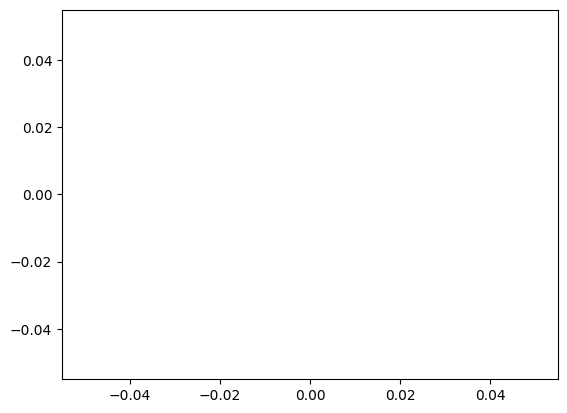

In [346]:
plt.plot(range(1000), costs)
plt.show()